In [1]:
#!/usr/bin/env python3

import pandas as pd
import numpy as np
from collections import defaultdict
import surprise
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def precision_recall_at_k(predictions, k, threshold):
    '''Return precision and recall at k metrics for each user.'''

    # First map the predictions to each user.
    user_est_true = defaultdict(list)
    for uid, _, true_r, est, _ in predictions:
        user_est_true[uid].append((est, true_r))

    precisions = dict()
    recalls = dict()
    for uid, user_ratings in user_est_true.items():

        # Sort user ratings by estimated value
        user_ratings.sort(key=lambda x: x[0], reverse=True)

        # Number of relevant items
        n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)

        # Number of recommended items in top k
        n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])
        
        # Number of relevant and recommended items in top k
        n_rel_and_rec_k = sum(((true_r >= threshold) and (est >= threshold))
                              for (est, true_r) in user_ratings[:k])

        # Precision@K: Proportion of recommended items that are relevant
        precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 1
        precision = sum(prec for prec in precisions.values()) / len(precisions)
        # Recall@K: Proportion of relevant items that are recommended
        recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 1
        recall = sum(rec for rec in recalls.values()) / len(recalls)
        #f_score = (2*precision*recall)/(precision+recall)
        
    return precision, recall#, f_score

In [3]:
def ndcg_at_k(predictions, k):
    dcgs = dict()
    idcgs = dict()
    # First map the predictions to each user.
    user_est_true = defaultdict(list)
    for uid, _, true_r, est, _ in predictions:
        user_est_true[uid].append((est, true_r))
        
    for uid, user_ratings in user_est_true.items():
        # Sort user ratings by estimated value
        user_ratings.sort(key=lambda x: x[0], reverse=True)
        
        #estimated rank
        rank_est = np.arange(1, len(user_ratings[:k])+1)
        discount_est = np.log2(rank_est+1)
        
        #Relevance 
        rel = [np.power(2,true_r)-1 for (_, true_r) in user_ratings[:k]]
        
        dcgs[uid] = sum(rel/discount_est)
        
        # Sort user ratings by true value
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        
        #estimated rank
        rank_true = np.arange(1, len(user_ratings[:k])+1)
        discount_true = np.log2(rank_true+1)
        
        #Relevance 
        rel_true = [np.power(2,true_r)-1 for (_, true_r) in user_ratings[:k]]
        
        idcgs[uid] = sum(rel_true/discount_true)
        
    dcg = sum(dcgu for (_,dcgu) in dcgs.items())
    idcg = sum(idcgu for (_,idcgu) in idcgs.items())
    return dcg/idcg

In [4]:
train = pd.read_csv('train.csv') 

reader = surprise.Reader(rating_scale=(1, 10))
data = surprise.Dataset.load_from_df(train[['User-ID', 'ISBN', 'Book-Rating']], reader)

In [10]:
# Tunning on number of factors and learning rate
factors = [5,10,15,20,50]
learning_rates = [0.0001, 0.001, 0.01, 0.02, 0.05]

In [11]:
m = len(factors)
n = len(learning_rates)
test_ndcg = np.zeros((m,n))
train_ndcg = np.zeros((m,n))
test_precision = np.zeros((m,n))
train_precision = np.zeros((m,n))
test_recall = np.zeros((m,n))
train_recall = np.zeros((m,n))
train_f_score = np.zeros((m,n))
test_f_score = np.zeros((m,n))
k = 10
threshold = 7

In [12]:
for i in range(len(factors)):
    for j in range(len(learning_rates)):
        fact = factors[i]
        rate = learning_rates[j]
        print ('\n No. of factors:{}, learning rate:{}'.format(fact, rate))
        data.split(n_folds=4)
        algo = surprise.SVD(n_factors = fact, lr_all = rate)#n_factors = , lr_all =, reg_all =
        
        
        precisions_train = []
        recalls_train = []
        f_scores_train = []
        ndcgs_train = []

        precisions_test = []
        recalls_test = []
        f_scores_test = []
        ndcgs_test = []
        
        for trainset, testset in data.folds():

            algo.train(trainset)

            predictions_train = algo.test(trainset.build_testset())
            precision_train, recall_train= precision_recall_at_k(predictions_train, k, threshold)
            ndcg_train = ndcg_at_k(predictions_train, k)

            precisions_train.append(precision_train)
            recalls_train.append(recall_train)
            f= 2*precision_train*recall_train/(precision_train+recall_train)
            f_scores_train.append(f)
            ndcgs_train.append(ndcg_train)


            predictions_test = algo.test(testset)
            precision_test, recall_test = precision_recall_at_k(predictions_test, k, threshold)
            ndcg_test = ndcg_at_k(predictions_test, k)

            precisions_test.append(precision_test)
            recalls_test.append(recall_test)
            f= 2*precision_test*recall_test/(precision_test+recall_test)
            f_scores_test.append(f)
            ndcgs_test.append(ndcg_test)    


        print ("\n Training Set accuracy:")
        print ("Precision: {}".format(np.mean(precisions_train)))
        train_precision[i,j]=np.mean(precisions_train)
        print ("Recall: {}".format(np.mean(recalls_train)))
        train_recall[i,j]=np.mean(recalls_train)
        print ("F-Score: {}".format(np.mean(f_scores_train)))
        train_f_score[i,j]=np.mean(f_scores_train)
        print ("NDCG: {}".format(np.mean(ndcgs_train)))
        train_ndcg[i,j]=np.mean(ndcgs_train)

        print ("\n Test Set accuracy:")
        print ("Precision: {}".format(np.mean(precisions_test)))
        test_precision[i,j]=np.mean(precisions_test)
        print ("Recall: {}".format(np.mean(recalls_test)))
        test_recall[i,j]=np.mean(recalls_test)
        print ("F-Score: {}".format(np.mean(f_scores_test)))
        test_f_score[i,j]=np.mean(f_scores_test)
        print ("NDCG: {}".format(np.mean(ndcgs_test)))
        test_ndcg[i,j]=np.mean(ndcgs_test)


 No. of factors:5, learning rate:0.0001

 Training Set accuracy:
Precision: 0.8496688088843382
Recall: 0.6395136439656309
F-Score: 0.729761270784798
NDCG: 0.7147436359219387

 Test Set accuracy:
Precision: 0.8197653077751748
Recall: 0.9197129330318864
F-Score: 0.8668581419684966
NDCG: 0.8002675519349979

 No. of factors:5, learning rate:0.001

 Training Set accuracy:
Precision: 0.8839284826135736
Recall: 0.6544497853870844
F-Score: 0.7520729407479031
NDCG: 0.7856430133400876

 Test Set accuracy:
Precision: 0.8306663455133694
Recall: 0.915736457437677
F-Score: 0.871119830178422
NDCG: 0.8197070890224438

 No. of factors:5, learning rate:0.01

 Training Set accuracy:
Precision: 0.9499471550780845
Recall: 0.6085601586249315
F-Score: 0.7418627669885653
NDCG: 0.8612245408408763

 Test Set accuracy:
Precision: 0.8632072194372734
Recall: 0.8165746944805606
F-Score: 0.8392308393617123
NDCG: 0.8221006822565696

 No. of factors:5, learning rate:0.02

 Training Set accuracy:
Precision: 0.97891887

In [13]:
test_f_score

array([[ 0.86685814,  0.87111983,  0.83923084,  0.81949752,  0.79469876],
       [ 0.86709153,  0.87306962,  0.83729739,  0.82245693,  0.80232692],
       [ 0.86629822,  0.87270662,  0.84019301,  0.82222003,  0.80790723],
       [ 0.86510558,  0.87111258,  0.8386218 ,  0.824913  ,  0.81494859],
       [ 0.86613206,  0.870098  ,  0.84245959,  0.83075679,  0.82553279]])

In [14]:
test_ndcg

array([[ 0.80026755,  0.81970709,  0.82210068,  0.8079537 ,  0.80142427],
       [ 0.79387255,  0.81821582,  0.82011675,  0.80817443,  0.80237479],
       [ 0.78885331,  0.81807615,  0.82069096,  0.80896975,  0.80502298],
       [ 0.78238939,  0.81724972,  0.82010265,  0.81309033,  0.80657068],
       [ 0.77723173,  0.81321761,  0.81602353,  0.81082659,  0.814928  ]])

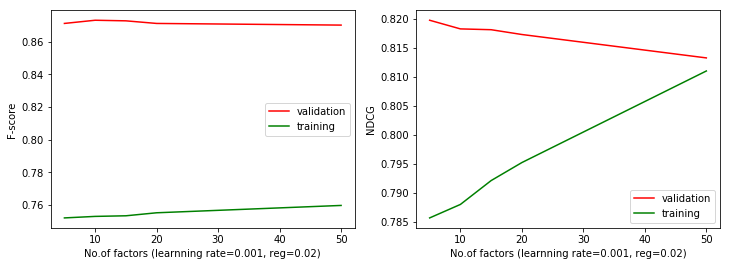

In [41]:
fig, ax = plt.subplots(1,2,figsize=(12,4))

ax[0].plot(factors, test_f_score[:,1], 'r')
ax[0].plot(factors, train_f_score[:,1], 'g')
ax[0].set_xlabel('No.of factors (learnning rate=0.001, reg=0.02)')
ax[0].set_ylabel('F-score')
ax[0].legend(['validation','training'])
ax[1].plot(factors, test_ndcg[:,1], 'r')
ax[1].plot(factors, train_ndcg[:,1], 'g')
ax[1].set_xlabel('No.of factors (learnning rate=0.001, reg=0.02)')
ax[1].set_ylabel('NDCG')
ax[1].legend(['validation','training'])

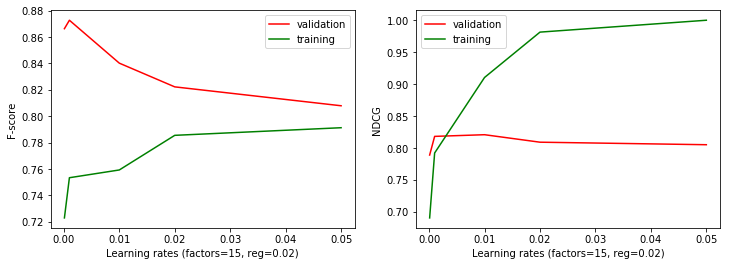

In [40]:
fig, ax = plt.subplots(1,2,figsize=(12,4))

ax[0].plot(learning_rates, test_f_score[2,:], 'r')
ax[0].plot(learning_rates, train_f_score[2,:], 'g')
ax[0].set_xlabel('Learning rates (factors=15, reg=0.02)')
ax[0].set_ylabel('F-score')
ax[0].legend(['validation','training'])
ax[1].plot(learning_rates, test_ndcg[2,:], 'r')
ax[1].plot(learning_rates, train_ndcg[2,:], 'g')
ax[1].set_xlabel('Learning rates (factors=15, reg=0.02)')
ax[1].set_ylabel('NDCG')
ax[1].legend(['validation','training'])